In [1]:
import pandas
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve as lk
from lightkurve.lightcurve import LightCurve
from bring_the_func import *
import os

In [2]:
os.chdir('/Users/willwaalkes/Desktop/PhD_Thesis/TFOP/Transit_Analysis/')

TOI = 2094.01

In [3]:
data = pandas.read_csv('Data/measurements/TIC356016119-01_20210601_APO_ip_measurements.csv',comment='#')

In [4]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')
TIC_IDs = params['TIC_ID']
TOIs = params['TOI']
err_kludge = 1.5*1.5

In [5]:
for i in range(len(TOIs)):
    if TOIs[i] == TOI:
        index = i

tic_id = TIC_IDs[index]
toi = TOIs[index]
observatory = 'APO'
print('TIC ',tic_id)
print('TOI ',toi)

TIC  356016119.0
TOI  2094.01


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

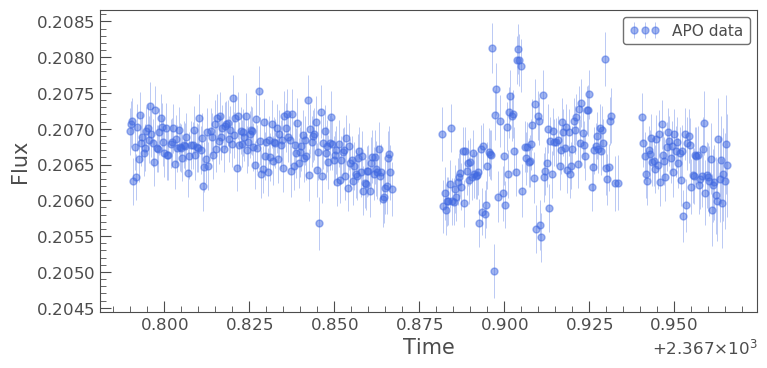

In [6]:
flux = np.array(data['rel_flux_T1'])
error = np.array(data['rel_flux_err_T1'])*err_kludge #inflates the error bars to give a best fit chi2=1
times = np.array(data['BJD_TDB'])

air = np.array(data['AIRMASS'])
airmass = (air-np.mean(air))/np.std(air)
sky = np.array(data['Sky/Pixel_T1'])
sky_flux = (sky-np.mean(sky))/np.std(sky)
x = np.array(data['X(IJ)_T1'])
xpos = (x-np.mean(x))/np.std(x)
y = np.array(data['X(IJ)_T1'])
ypos = (y-np.mean(y))/np.std(y)
comp = np.array(data['tot_C_cnts'])
comp_flux = (comp-np.mean(comp))/np.std(comp)

offset = 2457000
times = times-offset # This is just a constant offset to make the x-axis more readable

lc = LightCurve(time = times, flux = flux, flux_err = error)#.remove_outliers(sigma=3)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

Now let's turn this into a **lightkurve** object

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [7]:
planet_period = np.array(params['P (days)'][index]) # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = 89.1 #inclination in degrees
C1 = np.median(lc.flux) #C1 and C2 are the airmass correction parameters
C2 = 0.0
C3 = 0.0
C4 = 0.0
C5 = 0.0
C6 = 0.0
depth = C1*(1-float(ppm_depth)/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n) + np.array(Epoch)


for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]-1):
        if (mid_transit_times[i] <= lc.time[-1]+1):
            
            expected_t0 = mid_transit_times[i]
            print(f"Anticipated mid-transit time = {expected_t0:.6f}")
            print(f"Anticipated depth = {depth:.4f}")

Anticipated mid-transit time = 2367.818618
Anticipated depth = 0.2064


In [8]:
(((expected_t0-Epoch)/planet_period)*0.000385) # Propagated uncertainty

0.013860000000000004

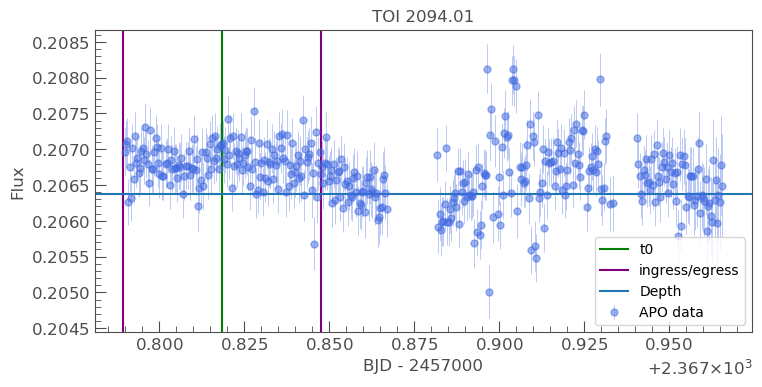

In [9]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title('TOI {}'.format(toi))
plt.xlabel('BJD - {}'.format(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.axhline(depth,label='Depth')
plt.legend()
plt.savefig('Figs/TOI_{}_NoFit.png'.format(toi))
plt.show()

In [10]:
# star_met = 0
# LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
# LD = LD_coeff[0]
# print(LD_coeff)
# print('--------')
# print(LD_err)

LD_coeff = [[0.40189188, 0.27528391]]
LD_err = [[0.00587292, 0.00961813]]
LD = LD_coeff[0]

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

8147.508712210501


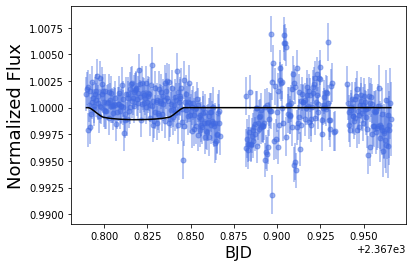

In [11]:
theta = [C1, C2, C3, C4, C5, C6, planet_radius, expected_t0]
static_params = [planet_radius, planet_period, planet_a, planet_i,
                 expected_t0, LD, offset, observatory, airmass, xpos, ypos, comp_flux, sky_flux, toi]

a = lnprob(theta, lc, planet_period, LD, airmass, xpos, ypos, comp_flux, sky_flux,
           planet_a, expected_t0, plot = True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [12]:
# intialize some walkers
ndim, nwalkers, nsteps = 8, 100, 90000
burnin = int(0.3*nsteps)

# these are initial parameters
C1_init = np.random.uniform(C1, C1, nwalkers)
C2_init = np.random.uniform(0,0.1, nwalkers)
C3_init = np.random.uniform(0,0.1, nwalkers)
C4_init = np.random.uniform(-0.1,0.1, nwalkers)
C5_init = np.random.uniform(-0.01,0.001, nwalkers)
C6_init = np.random.uniform(-0.1,0.1, nwalkers)
Rp_init = np.random.uniform(planet_radius-0.02, planet_radius+0.02, nwalkers)
t0_init = np.random.uniform(expected_t0-0.0139,expected_t0+0.0139, nwalkers)

labels = ['C1','C2','C3','C4','C5','C6','Rp/R*','T0'] #this is for the corner plot

p0 = np.transpose([C1_init, C2_init, C3_init, C4_init, C5_init, C6_init, Rp_init, t0_init])

In [13]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args = (lc, planet_period, LD,
                                        airmass, xpos, ypos, comp_flux, sky_flux,
                                        planet_a, expected_t0))

In [14]:
result = sampler.run_mcmc(p0, nsteps)

In [15]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
C1_sam, C2_sam, C3_sam, C4_sam, C5_sam, C6_sam, Rp_sam, t0_sam = samples

sig1_C1 = np.percentile(C1_sam, [16., 50., 84.])
sig1_C2 = np.percentile(C2_sam, [16., 50., 84.])
sig1_C3 = np.percentile(C3_sam, [16., 50., 84.])
sig1_C4 = np.percentile(C4_sam, [16., 50., 84.])
sig1_C5 = np.percentile(C5_sam, [16., 50., 84.])
sig1_C6 = np.percentile(C6_sam, [16., 50., 84.])
sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_t0 = np.percentile(t0_sam, [16., 50., 84.])

parameters = [sig1_C1[1],sig1_C2[1],sig1_C3[1],sig1_C4[1],sig1_C5[1],
              sig1_C6[1],sig1_Rp[1],sig1_t0[1]]

systematics = sig1_C1[1] + sig1_C2[1]*airmass + sig1_C3[1]*xpos \
            + sig1_C4[1]*ypos + sig1_C5[1]*comp_flux + sig1_C6[1]*sky_flux 

best_fit_model = systematics*BATMAN(Rp = sig1_Rp[1],t0 = sig1_t0[1],LD = LD,t = lc.time)

reduced_chisq = np.sum((lc.flux - best_fit_model)**2/(lc.flux_err)**2)/(len(lc.flux)-ndim)     
err_kludge = np.sqrt(reduced_chisq)
print(err_kludge)

np.savetxt(fname=f'Data/TOI_{toi}_samples.txt',X=samples)

1.0660749800220908


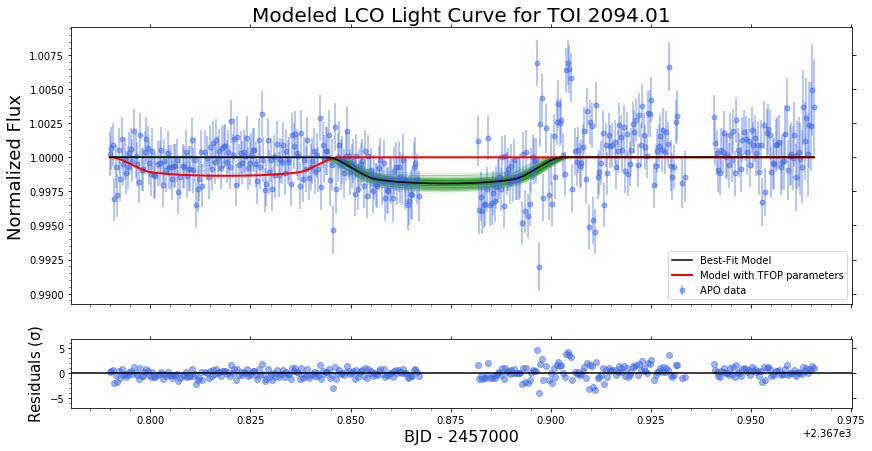

In [16]:
light_curve(lc, parameters, sampler, static_params, nsteps, Epoch, tic_id)

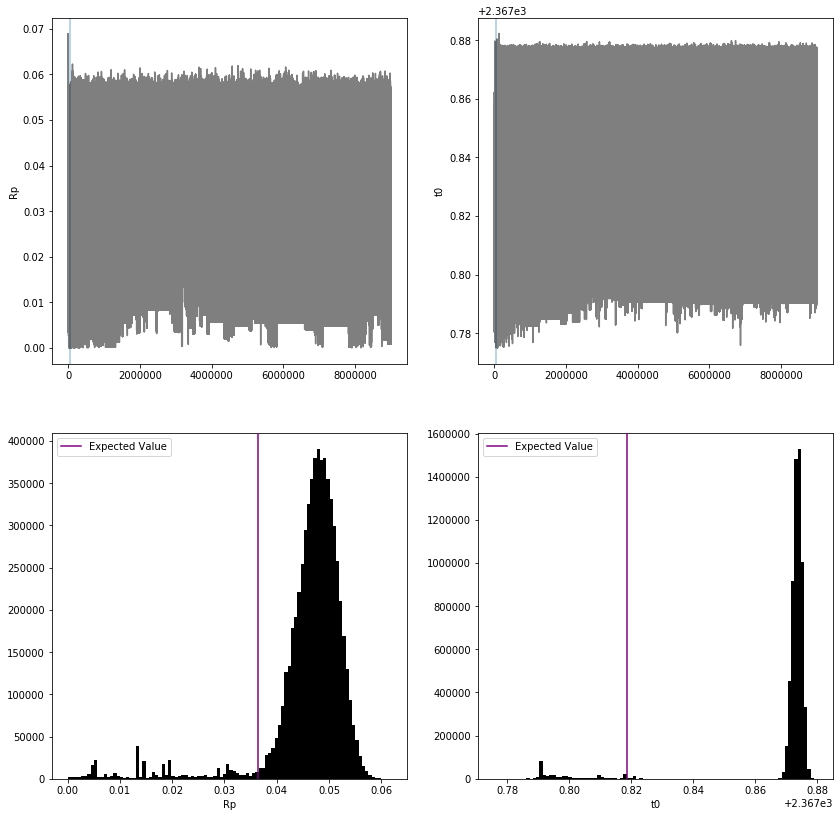

In [17]:
plot_chain(sampler, static_params, start=burnin, stop=nsteps)

In [18]:
for i in range(len(samples)):
    tau_f = emcee.autocorr.integrated_time(samples[i])
    print((nsteps-burnin)/tau_f)

[63000.]
[0.64346515]
[42.96442855]
[42.96442855]
[60.01497623]
[13.89275199]
[0.67114635]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 126000;
tau: [164349.10747986]

In [ ]:
#rms_plot(lc, parameters, static_params)

In [ ]:
#corner(samples, labels, toi)

In [19]:
# print('C1 = {:.5f}'.format(sig1_C1[1]),
#       '+ {:.5f}'.format(sig1_C1[2]-sig1_C1[1]),
#       '- {:.5f}'.format(sig1_C1[1]-sig1_C1[0]))

# print('C2 = {:.5f}'.format(sig1_C2[1]),
#       '+ {:.5f}'.format(sig1_C2[2]-sig1_C2[1]),
#       '- {:.5f}'.format(sig1_C2[1]-sig1_C2[0]))

print('Flux Deficit at Mid-Transit = {:.3f} ppt'.format((
      1-np.amin(best_fit_model/systematics))*1000))

print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

# print('a/R* = {:.3f}'.format(sig1_A[1]),
#       '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
#       '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

# print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
#       '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
#       '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

#print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(offset+sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print(f"Anticipated mid-transit time = {(offset+expected_t0):.6f} +/- 0.0139")

print(f"duration = {planet_period/(2*np.pi)/(planet_a)*24:.3f} hours")

results = Table({'rp':[sig1_Rp[1]],
                 'drp':[sig1_Rp[1]-sig1_Rp[0]],
                 't0':[sig1_t0[1]],
                 'dt0':[sig1_t0[1]-sig1_t0[0]]},
                names=['rp','drp','t0','dt0'])
ascii.write(results,f'Data/TOI_{toi}_bestfitparams.txt')

Flux Deficit at Mid-Transit = 1.886 ppt
Rp/R* = 0.0477 + 0.0037 - 0.0047
Rp (R_E) = 1.962 + 0.154 - 0.192
Mid-Transit Time = 2459367.873542 + 0.001512 - 0.001899
Anticipated mid-transit time = 2459367.818618 +/- 0.0139
duration = 1.264 hours
